# Particle Swarm Optimization and Firefly Algorithm

- **Andrew Gibson,** 8/15/25
- COGS 186: Genetic Algorithms
- Prof. Anjum Gupta

## Approach:
- Particle (aka "individual"): a solution to the non-convex function $f(\overrightarrow{x})$, which we are trying to minimize. The particle's position in the swarm is defined to be this vector, which represents a possible solution to the problem. The particle also has a velocity vector, and variables that record the "best" (lowest) value found so far. 
- Population: a collection of possible solutions to the function (i.e., a collection of Particles)
- Fitness: a function that tells us how good each Particle is. For a given solution $\overrightarrow{x}$, to minimize/maximize the objective function, the lower/higher the value of the objective function after plugging in the solution (i.e. $f(\overrightarrow{x})$), the higher the fitness/value of the solution.

Our Particle Swarm will proceed in the following steps:
1. Create the population (initialized with random positions and velocities)
2. Initialize the global best value and all the Particles' individual best values. All best fitness initializations should be to $-\infty$. (Code is already provided)
2. Update each Particle's individual best as well as the global best value found so far 
3. Update each Particle's velocity subject to the equation learned in class, and then update the Particle's position 
4. Update $w$
5. Repeat steps 3-4 until the solution has converged 
6. Plot your results (best values)

### Algorithm:
At every iteration, the position of each Particle gets updated. Each Particle has a position vector, $x$, and a velocity vector, $v$. The velocity vector is changed, and then each element of the velocity vector gets added to each element of the position vector. The length of $x$ and $v$ is equal to the dimension ($n$).

The velocity vector is updated in the following way: 

$v_i^{t+1}$ = inertia + cognitive velocity + social velocity 

- inertia = $w$ * $v_i^{t}$

- cognitive velocity = $c_1$ * $r_1$ * (personal best position - current position)

- social velocity = $c_2$ * $r_2$ * (global best position - current position)

And the position vector is then updated:

$x_i^{t+1}$ = $x_i^{t}$ + $v_i^{t+1}$

$r_1$ and $r_2$ are random numbers between 0 and 1, and $c_1$ and $c_2$ are the cognitive and social parameters, respectively.


The direction that the particle will move in each iteration depends on these three vectors (inertia, cognitive velocity, social velocity). Cognitive velocity pushes the Particle towards its personal best, and social (global) velocity pushes the Particle towards the global best. 

![picture](https://nathanrooy.github.io/posts/2016-08-17/simple-particle-swarm-optimization-with-python/pso-vector-1.png)


In [22]:
! conda info


     active environment : cogs-186
    active env location : /opt/homebrew/anaconda3/envs/cogs-186
            shell level : 2
       user config file : /Users/andrewgibson/.condarc
 populated config files : /Users/andrewgibson/.condarc
          conda version : 25.7.0
    conda-build version : 25.5.0
         python version : 3.10.11.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=m1
                          __conda=25.7.0=0
                          __osx=15.6.1=0
                          __unix=0=0
       base environment : /Users/andrewgibson/anaconda3  (writable)
      conda av data dir : /Users/andrewgibson/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/osx-arm64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/osx-arm64
                          https://repo.anaconda.com/pkgs/main/

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import operator
import math
import sys
from datetime import datetime
from util import plot_particles, record_to_pv

rng = np.random.default_rng(seed=186) # set seed for random num gen on uniform interval [0, 1)

The global variable dimension is set as the number of variables in the function we are minimizing. 

$f(\overrightarrow{x}) = x_{1}^{2} + (x_{2}+1)^{2} - 5cos(1.5x_{1} + 1.5) - 5cos(2x_{2}-1.5)$

In [2]:
dim = 2
def func(x):
    x_ = x[0]
    y_ = x[1]
    return x_**2 + (y_+1)**2 - 5*np.cos(1.5*x_ + 1.5) - 5 * np.cos(2* y_ - 1.50)

In [3]:
class Particle:
    def __init__(self, position):
        """
        position: the position of this Particle, a list of length 2
        velocity: the velocity of this Particle, a list of length 2
        best_position: the best position found so far by this Particle
        best_value: the best (lowest) value found so far by this Particle
        """
        self.position = position
        self.velocity = np.array([random.uniform(-2,2) for i in range(dim)])
        self.best_position = np.copy(position)
        self.best_fitness = -math.inf
    
    def fitness(self):
        """
        This fitness function is defined as the opposite value of this Particle
        when plugged into the function polynomial.
        """
        return -func(self.position)

    def update_velocity(self, w, c1, c2, best_position_global):
        """
        w, c1, c2: constants
        best_position_global: the best position found in the whole population so far 
        This function updates the Particle's velocity

        Particle's update: x ← x + v
        """
        r1 = rng.random(self.position.shape) # same effect as r1 = np.random.rand(2), but can control the seed
        r2 = rng.random(self.position.shape) # we need two different random numbers on uniform interval [0, 1)

        # x represents a candidate solution to f(x), vector x is position
        x = np.asarray(self.position, dtype=float) # position vector of the particle
        v = np.asarray(self.velocity, dtype=float) # velocity vector of the particle

        pbest = np.asarray(self.best_position, dtype=float) # particle's personal best position thus far
        gbest = np.asarray(best_position_global, dtype=float) # global best position of the whole swarm

        inertia = w * v # defined explicitly for understanding
        # w is the inertia weight which is a hyperparameter scalar value that acts as a dial
        # greater w = more exploration/momentum, lesser w = less exploration

        cog_v = c1 * r1 * (pbest - x) # a pull toward pbest scaled by rand
        soc_v = c2 * r2 * (gbest - x) # a pull toward gbest scaled by rand

        self.velocity = inertia + cog_v + soc_v # updated velocity is the sum of inertia + cognitive velocity + social velocity

    def update_position(self):
        """
        Updates the particle's position using its velocity
        """
        lo, hi = -100, 100 # set upper and lower bounds for particle update as interval [-100, 100]

        # new position = current position + current velocity
        # np.clip just restricts to set bounds
        self.position = np.clip(np.asarray(self.position, dtype=float) + self.velocity, lo, hi)

        

In [4]:
class PSO_Simulation:
    def __init__(self, initialPop, w, c1, c2):
        """
        initialPop: list of pop_size Particles
        w, c1, c2: constants
        best_position_global: the best position found by any Particle so far
        best_value_global: the best value found by any Particle so far 
        """
        self.particles = initialPop
        self.pop_size = len(initialPop)
        self.w = w  
        self.c1 = c1
        self.c2 = c2
        self.best_position_global = np.copy(initialPop[1].position)
        self.best_fitness_global = -np.inf # any real fitness will be an improvement

    def update_best(self, particle):
        """
        Updates the global/personal best position and value if the current Particle's position is better.
        """
        # first update the particle's best position and fitness if needed
        # then update the best position and  fitness if needed
        # update the personal best position
        current_fit = particle.fitness() # computed as -func(self.position)
        
        if current_fit > particle.best_fitness: # only if the new fitness is better than previous personal fit
            particle.best_fitness = current_fit # then update new fit
            particle.best_position = np.copy(particle.position) # then update new pos

        # update the global best position
        if current_fit > self.best_fitness_global: # only if the new fitness is better than previous swarm fit
            self.best_fitness_global = current_fit # then update new fit
            self.best_position_global = np.copy(particle.position) # then update new pos
        
            
    def run(self, iterations):
        best_global_values = [] # stores the best/smallest values of the function to minimize in each iteration
        particles_position = [] # stores the particles' positions in each iteration
        particles_velocity = [] # stores the particles' velocities in every iteration 
        weights = []            # stores the weights in each iteration

        # set up the initial population's pbests and gbests
        # reset global fitness
        self.best_fitness_global = -np.inf

        # for ea particle, set personal best fitness and position equal to current fit/pos
        for p in self.particles:
            self.update_best(p)
        
        for i in range(iterations):
            # update each particle's best fitness and position
            # update the global best fitness and position
            for p in self.particles: # for each particle
                # update velocity using equation with attractors: w, c1, c2, and gbest pos
                p.update_velocity(self.w, self.c1, self.c2, self.best_position_global)
            for p in self.particles: # for each particle
                p.update_position() # also update position within the bounds
            # for ea particle, recompute personal best fitness and position
            for p in self.particles:
                self.update_best(p)
            
            positions = []
            velocities = []

            # store current positions and velocities in lists above
            for particle in self.particles:
                positions.append(particle.position)
                velocities.append(particle.velocity)
                
            particles_position.append(positions)
            particles_velocity.append(velocities)
            weights.append(self.w) # also store current w
            
            self.w = self.w*0.98 # weight update (will decrease exploration over time)
            
            best_global_values.append(func(self.best_position_global)) # append objective value for current global best
            
        particles_record = [particles_position, particles_velocity]
        return weights, best_global_values, particles_record
    

In [5]:
def randomParticle():
    # create particle position as a random 2D array on interval [-30, 30)
    position = np.array([np.random.uniform(-30.0, 30.0) for i in range(dim)], dtype=float)

    return Particle(position)
def initialPopulation(pop_size):
    """
    Create inital population of a given size.
    Returns a list of random Particles
    """
    pop = []
    for i in range(pop_size):
        temp = randomParticle()
        pop.append(temp)
    
    return pop

In [6]:
def particleSwarm(iterations, pop_size, w, c1, c2):
    start = datetime.now() # retrieves the current date and time to start a timer

    pop=initialPopulation(pop_size) # create initial population
    # run the PSO and collect, weights, best global vals, and particle pos/vels
    weights, best_global_values, particles_record = PSO_Simulation(pop,w,c1,c2).run(iterations)
    
    print(f'Initial best value: {best_global_values[0]}')
    print(f'Final best value: {best_global_values[-1]}')
  
    plt.plot(best_global_values)
    plt.xlabel('iteration')
    plt.ylabel('best value')

    end = datetime.now() # stop timer
    print("Time Elapsed for Particle Swarm: " + str(end - start))
    return weights, particles_record , best_global_values

Initial best value: -6.636937915469295
Final best value: -7.391721225269822
Time Elapsed for Particle Swarm: 0:00:00.185249


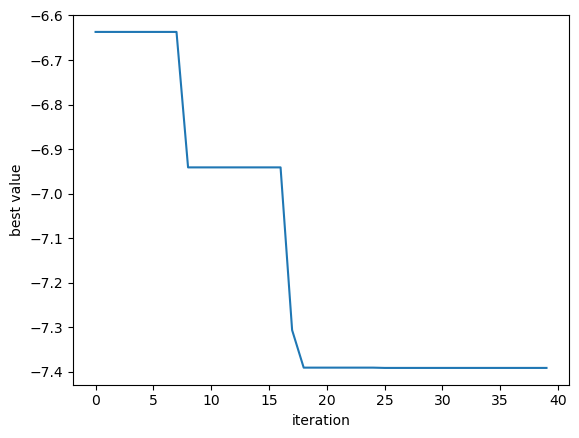

In [7]:
# default parameters
w = 1
c1 = 0.05
c2 = 0.05
iterations = 40
pop_size = 200


weights, particles_record, best_global_values = particleSwarm(
    iterations=iterations, pop_size=pop_size, w=w, c1=c1, c2=c2)

positions, velocities = record_to_pv(particles_record)

plot_particles(positions=positions, velocities=velocities, normalize_velocity=True, alphas=weights,
               progresses=best_global_values, name='PSO visualization', additonal_info=f"c1={c1}, c2={c2}")

Initial best value: -5.162696170153535
Final best value: -7.391485942396518
Time Elapsed for Particle Swarm: 0:00:00.043314


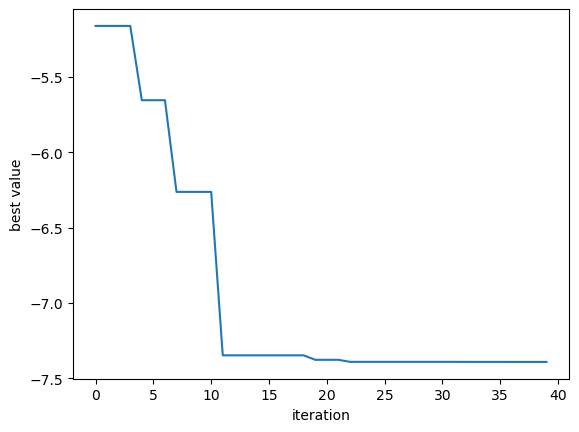

In [8]:
# stronger personal attractor
w = 1
c1 = 0.5
c2 = 0.05
iterations = 40
pop_size = 200

weights, particles_record, best_global_values = particleSwarm(
    iterations=iterations, pop_size=pop_size, w=w, c1=c1, c2=c2)

positions, velocities = record_to_pv(particles_record)

plot_particles(positions=positions, velocities=velocities, normalize_velocity=True, alphas=weights,
               progresses=best_global_values, name='PSO visualization, strong c1', additonal_info=f"c1={c1}, c2={c2}")

Initial best value: 0.9824324163499849
Final best value: -7.391884699582754
Time Elapsed for Particle Swarm: 0:00:00.055778


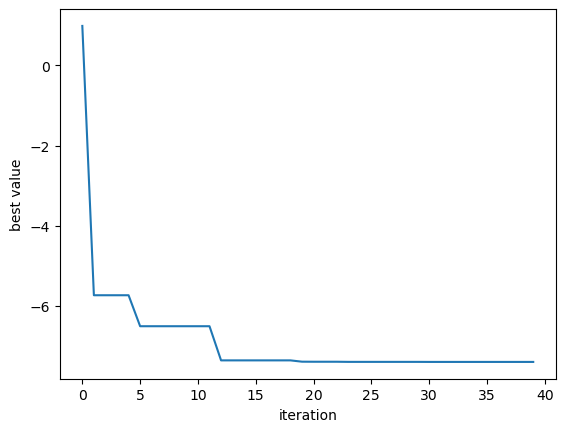

In [9]:
# stronger social attractor
w = 1
c1 = 0.5
c2 = 0.8
iterations = 40
pop_size = 200

weights, particles_record, best_global_values = particleSwarm(
    iterations=iterations, pop_size=pop_size, w=w, c1=c1, c2=c2)

positions, velocities = record_to_pv(particles_record)

plot_particles(positions=positions, velocities=velocities, normalize_velocity=True, alphas=weights,
               progresses=best_global_values, name='PSO visualization, strong c2', additonal_info=f"c1={c1}, c2={c2}")
# increasing c1 results in more exploration and therefore takes longer, but still

In [10]:
"""
~ Analysis of c1, c2, and w ~
------------------------------
The 'cognitive' attractor weight, c1, scales the pull towards each individual's personal best position and the 'social' attractor weight,
c2, scales the pull towards the swarm's global best position. Generally speaking, a larger c1 means that the particles individually explore
more which means that they can potentially find a more optimal value or escape local minima more easily, but it also means that it may
take much longer to converge. A larger c2 will pull everyone towards the global best more strongly which should result in faster
convergence, but therefore also increases the risk of converging too early and getting stuck in local minima. When both c1 and c2 are
relatively minimized compared to the interial weight w, such as in the first run here, inertia becomes the driving factor and we get a
slow stepwise curve.
"""

"\n~ Analysis of c1, c2, and w ~\n------------------------------\nThe 'cognitive' attractor weight, c1, scales the pull towards each individual's personal best position and the 'social' attractor weight,\nc2, scales the pull towards the swarm's global best position. Generally speaking, a larger c1 means that the particles individually explore\nmore which means that they can potentially find a more optimal value or escape local minima more easily, but it also means that it may\ntake much longer to converge. A larger c2 will pull everyone towards the global best more strongly which should result in faster\nconvergence, but therefore also increases the risk of converging too early and getting stuck in local minima. When both c1 and c2 are\nrelatively minimized compared to the interial weight w, such as in the first run here, inertia becomes the driving factor and we get a\nslow stepwise curve.\n"

# Firefly Algorithm 
The position update equation for the fireflies:

$$ x_{i}^{t+1} = x_{i}^{t} + \beta_{0}e^{-\gamma r_{ij}^{2}}(x_{j}^{t}-x_{i}^{t})+ \alpha \epsilon_{i}^{t}$$,
where $\epsilon$ is a vector of random numbers drawn from a Gaussian distribution centered around 0 with a standard deviation of 1.

$r_{ij}$ is the distance between fly i and fly j. We can use any distance function for distance r. For this script, we will use Euclidean distance.

$$ r_{ij} = \sqrt{\sum_{k=1}^{d} (x_{i,k}-x_{j,k})^{2}} $$

$\beta_{0} $ is the brightness at distance = 0. It is often set to 1.

In [11]:
class Firefly:
    def __init__(self, position):
        """
        position: the position of this firefly. 

        """
        self.position = position
    
    def fitness(self):
        """
        This fitness function is defined as the value of this Particle
        when plugged into the function polynomial.
        """
        return -func(self.position)

    def update_position(self, firefly, alpha, beta, gamma, l_bound=False, u_bound=False):
        """
        Updates the fly's position. Fireflies are attracted to greater brightness than their own and they move in the direction of brighter
        flies scaled the index of scatter according to this equation:
        """
        i = np.asarray(self.position, dtype=float) # position of ith firefly
        j = np.asarray(firefly.position, dtype=float) # position of jth firefly (brighter fly)

        # compute r as L2 norm (Euclidean distance b/w flies)
        r = np.linalg.norm(i - j)

        # compute attractiveness of β(r) = β0 * exp(-γ r^2)
        attract = float(beta) * np.exp(-float(gamma) * (r ** 2)) # need to use np.exp on arrays

        # compute epsilon (perturbation) as a random vector for every dimension in i
        epsilon = np.random.normal(loc=0.0, scale=1.0, size=i.shape) # loc establishes the center of distribution

        # update position according to equation
        new_pos = i + attract * (j - i) + float(alpha) * epsilon

        # fun clipping argument?
        if u_bound and l_bound == True:
            new_pos = np.clip(new_pos, l_bound, u_bound)

        self.position = new_pos

In [12]:
class FF_Simulation:
    def __init__(self, initialFlies, alpha, beta, gamma):
        """
        initialPop: list of pop_size Particles
        w, c1, c2: constants
        best_position_global: the best position found by any Particle so far
        best_value_global: the best value found by any Particle so far 
        """
        self.flies = initialFlies
        self.pop_size = len(initialFlies)
        self.alpha = alpha # amount of noise to add
        self.beta = beta # baseline attraction of brightness not accounting for distance
        self.gamma = gamma # light absorption factor: controls how attractiveness decreases with distance

    # create a static method to call on FF_Simulation
    def fly_fit(fly):
        return fly.fitness() # where fitness = -func(position)
            
    def run(self, iterations):
        best_global_values = [] # store the global best(smallest) value of the function to minimize in every iteration
        flies_position = []     # stores the position of each firefly in each iteration 
        alphas = []             # stores the alpha values of every iteration 
        
        for _ in range(iterations):
            # rank flies by fitness
            # sort by ascending brightness (where fittest fly is last)
            self.flies.sort(key=FF_Simulation.fly_fit) # call helper function to sort flies
            
            # update fly position
            # if the fly is not currently the best, update its position according to the formula
            # otherwise, random movement if the fly is currently the best
            brightest_ix = self.pop_size - 1 # ix of the brightest firefly after sorting

            for i in range(self.pop_size): # for every fly in the population
                # if it is the brightest fly then move it randomly
                if i == brightest_ix:
                    pos = np.asarray(self.flies[i].position, dtype=float) # extract each position
                    epsilon = np.random.normal(loc=0.0, scale=1.0, size=pos.shape) # define Gaussian noise
                    self.flies[i].position = pos + self.alpha * epsilon
                # if not, then move it towards all brighter flies
                else:
                    for j in range(i + 1, self.pop_size):
                        self.flies[i].update_position(self.flies[j], self.alpha, self.beta, self.gamma)
            
            # resort the flies by fitness after update. 
            # sort in ascending order, where the last fly should have the highest fitness. 
            self.flies.sort(key=FF_Simulation.fly_fit)
            
            # update the positions for plotting.
            positions = []
            for fly in self.flies:
                positions.append(fly.position)
            flies_position.append(np.array(positions))

            # update alpha
            alphas.append(self.alpha)
            self.alpha = 0.98*self.alpha # decay alpha so there is less exploration over time
            
            # update the best value
            best_global_values.append(func(self.flies[-1].position))
  
        return best_global_values, flies_position, alphas

In [13]:
def randomFlies():
    # range of position: [-10, 10]
    # create random position vector within bounds, cast to float for safety
    pos = np.random.uniform(-10.0, 10.0, size=dim).astype(float) # dim=2

    return Firefly(pos)

def initialSwarm(pop_size):
    """
    Create inital population of a given size.
    Returns a list of random flies.
    """
    pop = []
    for i in range(pop_size):
        temp = randomFlies()
        pop.append(temp)
    
    return pop

In [14]:
def fireFly(iterations, pop_size, alpha, beta, gamma):

    start = datetime.now()

    pop=initialSwarm(pop_size)
    best_global_values, positions, alphas =  FF_Simulation(pop,alpha,beta, gamma).run(iterations)
    
    print(f'Initial best value:{best_global_values[0]}')
    print(f'Final best value:{best_global_values[-1]}')
  
    plt.plot(best_global_values)
    plt.xlabel('iteration')
    plt.ylabel('best value')

    end = datetime.now()
    print("Time Elapsed for Firefly Swarm: " + str(end - start))
    return best_global_values, positions, alphas

Initial best value:-6.271844888952368
Final best value:-7.0332160945147715
Time Elapsed for Firefly Swarm: 0:00:02.295417


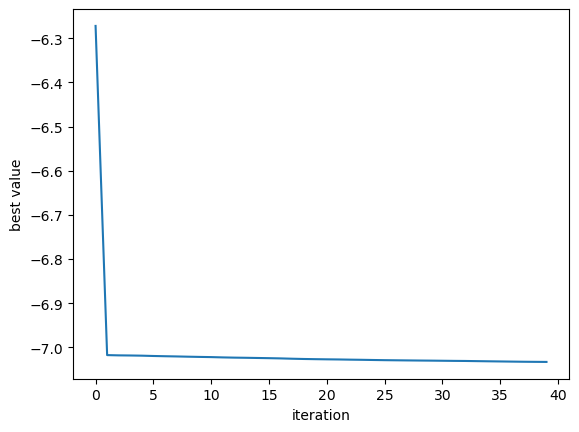

In [15]:
# 1) default parameters
iterations = 40
pop_size = 200
alpha = 0.0001
beta = 1
gamma = 1
best_global_values, positions, alphas = fireFly(iterations=iterations, pop_size=pop_size, alpha = alpha, beta = beta, gamma =gamma)
plot_particles(positions=positions, velocities=None, normalize_velocity=True, progresses=best_global_values,
               name='firefly', alphas=alphas, additonal_info=f"beta: {beta}, gamma: {gamma}")

Initial best value:-5.935126227434136
Final best value:-7.390265999580328
Time Elapsed for Firefly Swarm: 0:00:05.791593


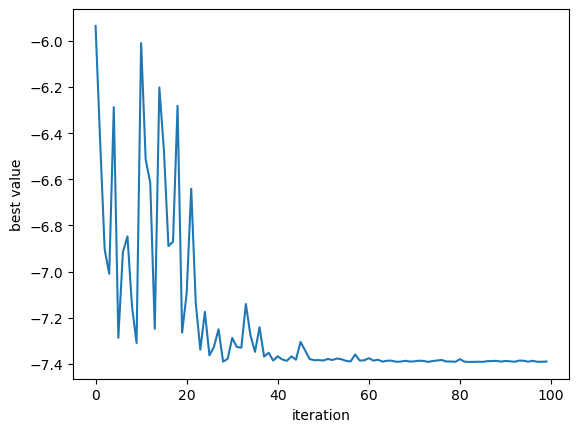

In [16]:
# 2) new parameters; higher alpha
iterations = 100
pop_size = 200
alpha = 0.5
beta = 1
gamma = 2.1
best_global_values, positions, alphas = fireFly(iterations=iterations, pop_size=pop_size, alpha = alpha, beta = beta, gamma =gamma)
plot_particles(positions=positions, velocities=None, normalize_velocity=True, progresses=best_global_values,
               name='firefly', alphas=alphas, additonal_info=f"beta: {beta}, gamma: {gamma}")

Initial best value:-5.565821996200654
Final best value:-7.391515660369498
Time Elapsed for Firefly Swarm: 0:00:05.824960


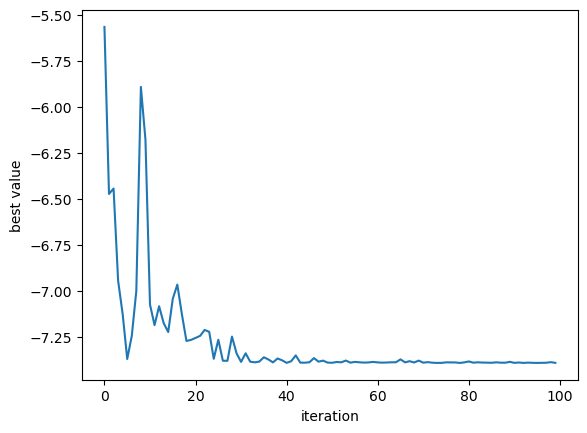

In [17]:
# 3) new parameters; higher beta
iterations = 100
pop_size = 200
alpha = 0.4
beta = 1.2
gamma = 2.1
best_global_values, positions, alphas = fireFly(iterations=iterations, pop_size=pop_size, alpha = alpha, beta = beta, gamma =gamma)
plot_particles(positions=positions, velocities=None, normalize_velocity=True, progresses=best_global_values,
               name='firefly', alphas=alphas, additonal_info=f"beta: {beta}, gamma: {gamma}")


Initial best value:-6.813838059328928
Final best value:-7.391479946758555
Time Elapsed for Firefly Swarm: 0:00:05.793571


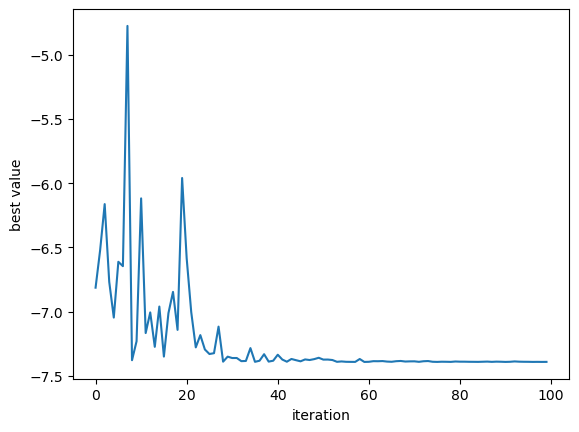

In [18]:
# 4) new parameters; high gamma
iterations = 100
pop_size = 200
alpha = 0.4
beta = 1
gamma = 3
best_global_values, positions, alphas = fireFly(iterations=iterations, pop_size=pop_size, alpha = alpha, beta = beta, gamma =gamma)
plot_particles(positions=positions, velocities=None, normalize_velocity=True, progresses=best_global_values,
               name='firefly', alphas=alphas, additonal_info=f"beta: {beta}, gamma: {gamma}")


Initial best value:-5.46420456487575
Final best value:-7.38545577933881
Time Elapsed for Firefly Swarm: 0:00:05.906664


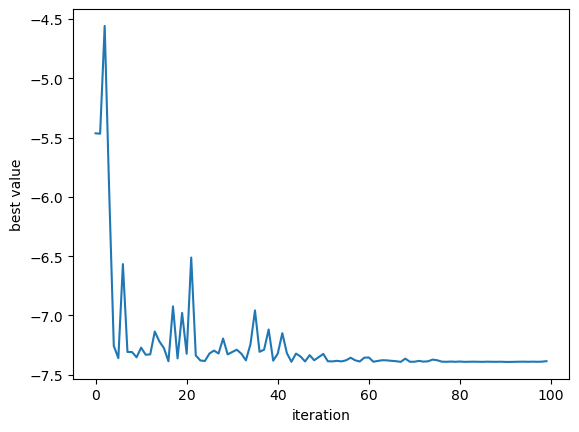

In [19]:
# 5) new parameters; higher gamma
iterations = 100
pop_size = 200
alpha = 0.4
beta = 1
gamma = 4
best_global_values, positions, alphas = fireFly(iterations=iterations, pop_size=pop_size, alpha = alpha, beta = beta, gamma =gamma)
plot_particles(positions=positions, velocities=None, normalize_velocity=True, progresses=best_global_values,
               name='firefly', alphas=alphas, additonal_info=f"beta: {beta}, gamma: {gamma}")


Initial best value:-6.499399701565991
Final best value:-7.391135619652321
Time Elapsed for Firefly Swarm: 0:00:05.909882


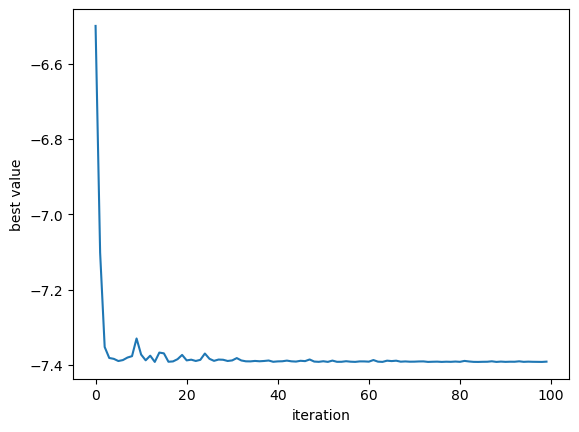

In [20]:
# 6) new parameters; lower gamma
iterations = 100
pop_size = 200
alpha = 0.4
beta = 1
gamma = 0.3
best_global_values, positions, alphas = fireFly(iterations=iterations, pop_size=pop_size, alpha = alpha, beta = beta, gamma =gamma)
plot_particles(positions=positions, velocities=None, normalize_velocity=True, progresses=best_global_values,
               name='firefly', alphas=alphas, additonal_info=f"beta: {beta}, gamma: {gamma}")

In [21]:
"""
~ Analysis of firefly algorithm variables ~
In the first plot with a tiny alpha, there is no random perturbation, so there is almost no improvement. In the second plot, with higher
alpha, there is more exploration shown as greater variance in best value and the result is a more optimal final score (although still
worse than PSO). In the third plot with higher beta, it might take marginally less time for flies to be drawn towards brighter ones, but 
with a small gamma, distance doesn't have a huge effect on attraction. As we incrementally increase gamma, seen in plots 4-6, we can observe
the control gamma exerts over the gravitation of flies towards brighter ones. A higher gamma means that distance tuncates velocity towards
flies with higher absolute brightness, meaning that each fly conducts a more localized search.

alpha : scales Gaussian noise; a higher alpha means more exploration which potentially avoids local minima

beta : baseline attractiveness when distance = 0; higher beta speeds up convergence, but could happen to early
    - modulates the coupling term (how hard the fireflies pull on each other)

gamma : controls the strength of distance's dampening of the attractiveness of brightness
"""

"\n~ Analysis of firefly algorithm variables ~\nIn the first plot with a tiny alpha, there is no random perturbation, so there is almost no improvement. In the second plot, with higher\nalpha, there is more exploration shown as greater variance in best value and the result is a more optimal final score (although still\nworse than PSO). In the third plot with higher beta, it might take marginally less time for flies to be drawn towards brighter ones, but \nwith a small gamma, distance doesn't have a huge effect on attraction. As we incrementally increase gamma, seen in plots 4-6, we can observe\nthe control gamma exerts over the gravitation of flies towards brighter ones. A higher gamma means that distance tuncates velocity towards\nflies with higher absolute brightness, meaning that each fly conducts a more localized search.\n\nalpha : scales Gaussian noise; a higher alpha means more exploration which potentially avoids local minima\n\nbeta : baseline attractiveness when distance = 0; 